<a href="https://colab.research.google.com/github/RobertaAleksaite/Al_Fl/blob/main/%E2%80%9ESveiki%2C_tai_%E2%80%93_%E2%80%9EColaboratory%E2%80%9C%E2%80%9C_kopija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Impotuojami irankiai
import numpy as np
import random
from collections import Counter
from tabulate import tabulate
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#Ikeliami duomenys
df = np.load('flatland_train.npz')
X = df['X']
y = df['y']

y[y != 0] -= 2 #Keiciamos y vertes, kad butu paeiliui einantys skaiciai
X = X / 255. #Normalizuojamos X vertes

In [ ]:
print('Duomenu skaicius:',X.shape[0])
print('Figuru kiekis pagal kategorijas:')
print(tabulate(sorted(Counter(y).items()), headers=('Kat.','Kiekis'),tablefmt='fancy_grid'))
print('Matau, kad kiekiai skirtingi, galbut praverstu pasirinkti subalansuota treniravimo grupe.')

Duomenu skaicius: 10000
Figuru kiekis pagal kategorijas:
╒════════╤══════════╕
│   Kat. │   Kiekis │
╞════════╪══════════╡
│      0 │     1381 │
├────────┼──────────┤
│      1 │     2853 │
├────────┼──────────┤
│      2 │     1868 │
├────────┼──────────┤
│      3 │     2137 │
├────────┼──────────┤
│      4 │     1761 │
╘════════╧══════════╛
Matau, kad kiekiai skirtingi, galbut praverstu pasirinkti subalansuota treniravimo grupe.


In [ ]:
#Duomenis atskiriu i treniravimo ir testavimo grupes (90%:10%)
#Grupese islaikau y reiksmiu proporcija
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)
X_train=X_train.reshape(X_train.shape[0],50,50,1)
X_test=X_test.reshape(X_test.shape[0],50,50,1)

In [ ]:
#Konstruoju modeli
model = keras.models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1]),
    layers.BatchNormalization(axis=-1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(axis=-1),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
#Treniruoju modeli
#Teko ekspermentuoti ieskant optimaliausio epochu skaiiciaus, kad nebutu overfit
loss = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=128)

Epoch 1/25
71/71 [==============================] - 8s 17ms/step - loss: 1.4024 - accuracy: 0.4132 - val_loss: 1.7608 - val_accuracy: 0.1710
Epoch 2/25
71/71 [==============================] - 1s 11ms/step - loss: 0.7381 - accuracy: 0.7254 - val_loss: 2.1448 - val_accuracy: 0.1420
Epoch 3/25
71/71 [==============================] - 1s 11ms/step - loss: 0.3015 - accuracy: 0.9216 - val_loss: 3.8576 - val_accuracy: 0.1380
Epoch 4/25
71/71 [==============================] - 1s 12ms/step - loss: 0.1899 - accuracy: 0.9598 - val_loss: 5.1237 - val_accuracy: 0.1380
Epoch 5/25
71/71 [==============================] - 1s 12ms/step - loss: 0.1476 - accuracy: 0.9716 - val_loss: 4.9512 - val_accuracy: 0.1460
Epoch 6/25
71/71 [==============================] - 1s 12ms/step - loss: 0.1186 - accuracy: 0.9783 - val_loss: 4.1222 - val_accuracy: 0.2110
Epoch 7/25
71/71 [==============================] - 1s 11ms/step - loss: 0.0953 - accuracy: 0.9818 - val_loss: 2.4370 - val_accuracy: 0.3850
Epoch 8/25
71

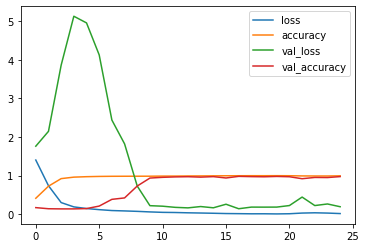

In [ ]:
#Treniravimo eigos vizualizacija
pd.DataFrame(loss.history).plot()

In [ ]:
#Tikrinu modelio tiksluma
pred = model.predict(X_test).argmax(axis=1)
print('Tikslumas testavimo grupeje - {0:.02%}'.format((pred == y_test).mean()))

fail = X_test[pred != y_test]
print('Klaidu skaicius:',fail.shape[0],'is',X_test.shape[0])

32/32 [==============================] - 0s 4ms/step
Tikslumas testavimo grupeje - 97.40%
Klaidu skaicius: 26 is 1000


In [ ]:
model.save('final_model.h5')